In [1]:
# -*- coding: utf-8 -*-
import os, time, glob,sys
import PIL.Image as Image
import numpy as np
import cv2
from keras import backend as K
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract
from keras.models import Model
from keras.optimizers import Adam
from skimage.measure import compare_psnr, compare_ssim
from util import getdatset
%matplotlib inline
import matplotlib.pyplot as plt

/opt/software/anaconda/3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_xh,test_xh,train_xl,test_xl = getdatset(1000,1000)

In [3]:
def myKLD(y_true,y_pred):
    u = K.clip(y_true,1,255)
    f = K.clip(y_pred,1,255)
    z=K.log(u)
    KLD = K.sum((f*K.exp(-z/2)*K.log(f / K.exp(z)) - f*K.exp(-z/2) + K.exp(z/2)),axis=-1)
    return KLD

def res_block(input_img):
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input_img)
    x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
    x = Activation('relu')(x) 
    x = Subtract()([input_img, x])
    return x
        
def DnCNN():
    
    inpt = Input(shape=(128,128,1), name='tmp_input')
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = Activation('relu')(x)
    # 15 layers, Conv+BN+relu
    for i in range(15):
        x = res_block(x) 
    # last layer, Conv
    x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    model = Model(inputs=inpt, outputs=x)
    
    return model

In [4]:
model = DnCNN()
model.compile(optimizer=Adam(), loss='mse')
history=model.fit(train_xl,train_xh,
                      epochs=50,
                      batch_size=8,
                      shuffle=True,
                      verbose=1,
                      validation_data=(test_xl,test_xh),)

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 72s 72ms/step - loss: 486.3055 - val_loss: 148.2681
Epoch 2/50
1000/1000 [==============================] - 68s 68ms/step - loss: 139.3949 - val_loss: 138.1801
Epoch 3/50
1000/1000 [==============================] - 68s 68ms/step - loss: 135.1318 - val_loss: 133.0189
Epoch 4/50
1000/1000 [==============================] - 68s 68ms/step - loss: 132.6303 - val_loss: 135.3219
Epoch 5/50
1000/1000 [==============================] - 68s 68ms/step - loss: 130.9804 - val_loss: 128.5396
Epoch 6/50
1000/1000 [==============================] - 68s 68ms/step - loss: 130.1681 - val_loss: 132.4864
Epoch 7/50
1000/1000 [==============================] - 68s 68ms/step - loss: 129.2693 - val_loss: 126.5797
Epoch 8/50
1000/1000 [==============================] - 68s 68ms/step - loss: 129.0263 - val_loss: 126.6031
Epoch 9/50
1000/1000 [==============================] - 68s 68ms/step - loss: 128.2200 -

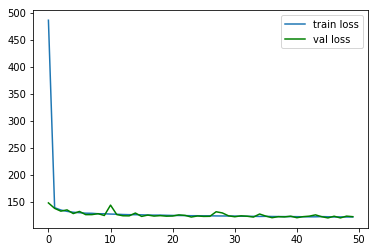

In [5]:
import pylab as pl
pl.figure()
pl.plot(history.history['loss'], label='train loss')
pl.plot(history.history['val_loss'], c='g', label='val loss')
pl.legend()

In [6]:
model.save("DnCNN15_MSE_0605.h5")
model.save_weights("DnCNN15_MSE_0605w.h5")